# CNN

In [1]:
##################################################
# Imports
##################################################

import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model

##################################################
# Set current directory
##################################################

currentDirectory=os.getcwd()#current working directory

DATA_BASE_FOLDER = '../data'

In [28]:
# function to plot accuracy on TS and VS in same figure
def plot_accuracy(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.epoch,history.history['accuracy'], label = "Accuracy on TS")
    plt.plot(history.epoch,history.history['val_accuracy'], label = "Accuracy on VS")
    plt.legend()
    plt.title('accuracy')

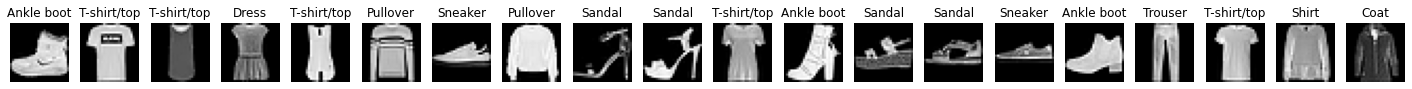

In [2]:
##################################################
# Load dataset
##################################################

x_train = np.load(os.path.join(DATA_BASE_FOLDER, 'train.npy'))
x_valid = np.load(os.path.join(DATA_BASE_FOLDER, 'validation.npy'))
x_test = np.load(os.path.join(DATA_BASE_FOLDER, 'test.npy'))
y_train = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'train.csv'))['class'].values
y_valid = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'validation.csv'))['class'].values
y_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot random images of different classes
plt.figure(figsize=(25, 5))
for idx in range(20):
    plt.subplot(1, 20, idx + 1)
    img = x_train[idx].reshape(28, 28)
    plt.title(f'{y_labels[y_train[idx]]}')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

In [43]:
#SET SIZE = size of training set to use. Use 50000 to use full TS
size = 20000

#For better numerical stability is advisible to divide by 255
x_train_sc=x_train[0:size]/255
x_valid_sc=x_valid[0:int(size/5)]/255
x_test_sc =x_test/255

y_train_sc=y_train[0:size]
y_valid_sc=y_valid[0:int(size/5)]

x_train_sc=x_train_sc.reshape(size,28,28,1)
x_valid_sc=x_valid_sc.reshape(int(size/5),28,28,1)

print("Size of x_train_sc is now: {}".format(x_train_sc.shape))
print("Size of x_valid_sc is now: {}".format(x_valid_sc.shape))

print("Size of y_train_sc is now: {}".format(y_train_sc.shape))
print("Size of y_valid_sc is now: {}".format(y_valid_sc.shape))

Size of x_train_sc is now: (20000, 28, 28, 1)
Size of x_valid_sc is now: (4000, 28, 28, 1)
Size of y_train_sc is now: (20000,)
Size of y_valid_sc is now: (4000,)


In [49]:
##### First Neural Network - 2 Convolutional layers (with pooling) and a single dense final layer ####
def model1(input_shape):
    X_input = Input(input_shape)
    X = Conv2D(filters=32,
               kernel_size=(3, 3), 
               strides=(1, 1), 
               name='conv0', 
               padding='same',
               activation='relu')(X_input)#'same' preserve the dimension of input through the convolutions
    X= MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same')(X)
    X=Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu')(X)
    X=MaxPooling2D((2, 2), strides=(2, 2), padding='same')(X)
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(units=10, activation='softmax')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='model1')

    return model

In [50]:
input_shape=(28,28,1)  
model1 = model1(input_shape)

model1.compile(optimizer = "adam", 
               loss =  'sparse_categorical_crossentropy',
               metrics = ["accuracy"])

model1.summary()

Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                62730

In [51]:
history = model1.fit(x = x_train_sc, y = y_train_sc, epochs = 4, batch_size = 128, validation_data=(x_valid_sc, y_valid_sc))

Train on 20000 samples, validate on 4000 samples
Epoch 1/4
20000/20000 [==============================] - 28s 1ms/sample - loss: 0.6711 - accuracy: 0.7646 - val_loss: 0.4752 - val_accuracy: 0.8325
Epoch 2/4
20000/20000 [==============================] - 29s 1ms/sample - loss: 0.4138 - accuracy: 0.8521 - val_loss: 0.3921 - val_accuracy: 0.8637
Epoch 3/4
20000/20000 [==============================] - 28s 1ms/sample - loss: 0.3592 - accuracy: 0.8730 - val_loss: 0.3632 - val_accuracy: 0.8708
Epoch 4/4
20000/20000 [==============================] - 28s 1ms/sample - loss: 0.3249 - accuracy: 0.8841 - val_loss: 0.3448 - val_accuracy: 0.8808


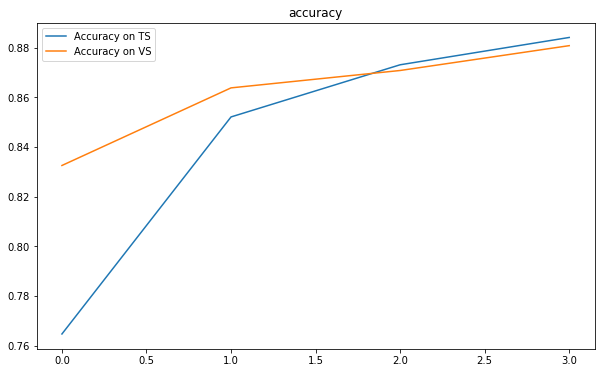

In [52]:
plot_accuracy(history)

In [33]:
# scores = model1.evaluate(x_test, y_test, verbose=2)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
print()
print ("Loss = " + str(preds[0]))
print ("Valid set Accuracy = " + str(preds[1]))